# 3️⃣ Statistical Inference
**designed by:** [datamover.ai](https://www.datamover.ai)

In [65]:
# Load libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from IPython.display import display
from pandas.api.types import CategoricalDtype
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# import helper function made ad-hoc
from c3_helpers import (chain_snap, chisquare, classification_report,
                        correlation_analysis, encode_categorical_features,
                        independent_t_test, normlize_data)

# Set random seed
np.random.seed(42)

**1 Start from the Summary coming from the Exploratory Data Analysis (EDA)**

- Target: `Income` with a prevalence 0.24;
- There are 8 nominal, 3 numerical, 2 ordinal and 2 discrete features;
- There are 3386 (1.95%) missing values and they are encoded as ` ?`;
- One can note that any categorical feature always contains a space ` ` prior to any text, e.g., ` Other-service`, ` Exec-managerial`. We will create a pre-processed dataframe with spaces all removed; 
- All Nominal features are highly imbalanced with several facets. It is expected to cluster some of the facets in order to create a more predictive feature.
- `Education-Num` have the same amount of elements (16); hence it is assumed that it provides the order to `Education`; we can apply some feature engineering procedures which combine both features leading to an ordinal feature. Furthermore, education has a spike at values 9 and 10;
- `Age` and `final weight` are heavy-tailed; hence we expect to apply a log transformation in order to normalise the features;
- `Hours per week` have a significant spike at 40. We can consider converting this feature from an ordinal feature with 3 facets, namely:
 - `part-time` for `Hours per week < 40`
 - `full-time` for `Hours per week = 40`
 - `Freelancers or entrepreneurs` for `Hours per week > 40`
- `Capital Gain` and `Capital Loss` have extreme values, and at the same time, the majority of the sample is 0 (hence very low variance. It is not clear whether these features can be predictive. 

**2 Begin to process the dataset accordingly, e.g., by dealing with missing values, feature engineering and transformation;**
- 💁‍♂️ Try to tailor the [datatype](https://pandas.pydata.org/docs/user_guide/basics.html#basics-dtypes) as much as possible.

In [66]:
data = (
    # load csv
    pd.read_csv("./data/data_train.csv")
    .pipe(
        chain_snap,
        fn=lambda df: df.isna().sum().sum(),
        msg="o Number of missing values prior processing",
    )
    # remove every space in the string
    .apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    # drop duplicates rows
    .pipe(
        chain_snap,
        fn=lambda x: x.duplicated().sum(),
        msg="o Number of duplicate rows that will be removed",
    )
    .drop_duplicates()
)

# load data info
data_info = pd.read_csv("./data/data_info.csv", index_col=0)

TARGET = "Income"

# display some info
display(data.head(3))
display(data_info.transpose())
print(f"o Size dataframe = {data.shape}")
print(f'o Data type in Dataset: {data_info["data_type"].unique()}')
print(f"o Columns: {data_info.index.tolist()}")

o Number of missing values prior processing: 0
o Number of duplicate rows that will be removed: 17


,Income,Age,Workclass,final weight,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,<=50K,25,Private,252752,Some-college,10,Never-married,Transport-moving,Not-in-family,White,Female,0,0,45,United-States
1,<=50K,33,Private,121488,Bachelors,13,Never-married,Sales,Not-in-family,White,Female,0,0,40,United-States
2,<=50K,39,Private,80680,Some-college,10,Divorced,Machine-op-inspct,Own-child,White,Female,0,0,40,United-States


,Income,Age,Workclass,final weight,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
data_type,ordinal,discrete,nominal,numerical,ordinal,ordinal,nominal,nominal,nominal,nominal,nominal,numerical,numerical,discrete,nominal
missing values,0,0,1491,0,0,0,0,1496,0,0,0,0,0,0,475
type of noise,noise-free,noise-free,noise-free,noise-free,noise-free,noise-free,noise-free,noise-free,noise-free,noise-free,noise-free,noise-free,noise-free,noise-free,noise-free


o Size dataframe = (26031, 15)
o Data type in Dataset: ['ordinal' 'discrete' 'nominal' 'numerical']
o Columns: ['Income', 'Age', 'Workclass', 'final weight', 'Education', 'Education-Num', 'Marital Status', 'Occupation', 'Relationship', 'Ethnic group', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Country']


In [67]:
# Discover Education order
education_order = (
    data.loc[:, ["Education", "Education-Num"]]
    .drop_duplicates()
    .sort_values(by="Education-Num", ascending=True)
    .set_index("Education")
)
display(education_order)

,Education-Num
Education,
Preschool,1
1st-4th,2
5th-6th,3
7th-8th,4
9th,5
10th,6
11th,7
12th,8
HS-grad,9


In [68]:
columns_dtype = {
    "Income": "category",
    "Age": "Int8",
    "Workclass": "category",
    "final weight": "Int64",
    "Education": CategoricalDtype(categories=list(education_order.index), ordered=True),
    "Education-Num": "Int8",
    "Marital Status": "category",
    "Occupation": "category",
    "Relationship": "category",
    "Ethnic group": "category",
    "Sex": "category",
    "Capital Gain": "Int64",
    "Capital Loss": "Int64",
    "Hours per week": "Int8",
    "Country": "category",
}

# Coerce better data type
data = data.astype(columns_dtype)

In [69]:
# Check Education order. Note that categories are ordered
display(data["Education"])

0        Some-college
1           Bachelors
2        Some-college
3             HS-grad
4             5th-6th
             ...     
26043       Bachelors
26044         HS-grad
26045       Bachelors
26046         Masters
26047       Bachelors
Name: Education, Length: 26031, dtype: category
Categories (16, object): ['Preschool' < '1st-4th' < '5th-6th' < '7th-8th' ... 'Bachelors' < 'Masters' < 'Prof-school' < 'Doctorate']

**3. For supervised learning, study the relationship between features, a.k.a. independent variables (IV), with the target, a.k.a. the dependent variable (DV).**

- **a.** Apply $\chi^{2}$ ([chi-square](https://www.investopedia.com/terms/c/chi-square-statistic.asp)) between two **Nominal** variables;
- **b.** Carry out $\chi^{2}$ ([chi-square](https://www.investopedia.com/terms/c/chi-square-statistic.asp)) or a [correlation](https://www.statisticshowto.com/probability-and-statistics/correlation-analysis/) analysis between two **Ordinal** features.
- **c.** Study the [correlation](https://www.statisticshowto.com/probability-and-statistics/correlation-analysis/) for both **Discrete** and **Numerical** features.
- **d.** Use an appropriate version of the [t-test](https://www.investopedia.com/terms/t/t-test.asp) or [analysis of variance](https://www.investopedia.com/terms/a/anova.asp) (ANOVA) to study the relationship between **quantitative** and **categorical** variables.   
- **e.** ‼️ whenever possible, plot the variables to assess whether the results coming from the statistical test are driven by outliers or imbalanced facets;
- **f.** If necessary, transform or construct new features and re-apply the same statistical test;


**a. Analysis of nominal features**

In [70]:
display(data_info.loc[lambda x: x["data_type"] == "nominal"].transpose())

# get list of nominal features and remove Education from the list as we analyzed before together with Education-Num
nominal_list = list(data_info.loc[lambda x: x["data_type"] == "nominal"].index)

,Workclass,Marital Status,Occupation,Relationship,Ethnic group,Sex,Country
data_type,nominal,nominal,nominal,nominal,nominal,nominal,nominal
missing values,1491,0,1496,0,0,0,475
type of noise,noise-free,noise-free,noise-free,noise-free,noise-free,noise-free,noise-free


In [71]:
# loop through nominal feature and apply chi2
df_chi2_nominal = pd.DataFrame()  # initialize empty dataframe

# Loop through nominal feature apply chi2 and check facet balancing
for nominal in nominal_list:
    print(f"o chi2 on feature: {nominal}")
    # assess if there is a relationship with Income
    df_chi2_nominal = pd.concat(
        [
            df_chi2_nominal,
            chisquare(data=data, groups=nominal, categories=TARGET, show=True),
        ],
        ignore_index=True,
    )

o chi2 on feature: Workclass


,<=50K,>50K,Total count,Total count %
Workclass,,,,
?,1336,155,1491,5.73
Federal-gov,480,300,780,3.00
Local-gov,1226,493,1719,6.60
Never-worked,5,0,5,0.02
Private,14119,3976,18095,69.51
Self-emp-inc,390,491,881,3.38
Self-emp-not-inc,1420,574,1994,7.66
State-gov,774,282,1056,4.06
Without-pay,10,0,10,0.04


,test-type,grouping-var,categories,chi-square,df,p-value,stat-sign
0,chisquare,Workclass,Income,820.258741,8,8.848495e-172,True


o chi2 on feature: Marital Status


,<=50K,>50K,Total count,Total count %
Marital Status,,,,
Divorced,3182,360,3542,13.61
Married-AF-spouse,9,8,17,0.07
Married-civ-spouse,6663,5345,12008,46.13
Married-spouse-absent,323,27,350,1.34
Never-married,8096,403,8499,32.65
Separated,769,57,826,3.17
Widowed,718,71,789,3.03


,test-type,grouping-var,categories,chi-square,df,p-value,stat-sign
0,chisquare,Marital Status,Income,5142.013125,6,0.0,True


o chi2 on feature: Occupation


,<=50K,>50K,Total count,Total count %
Occupation,,,,
?,1341,155,1496,5.75
Adm-clerical,2597,401,2998,11.52
Armed-Forces,6,1,7,0.03
Craft-repair,2517,755,3272,12.57
Exec-managerial,1664,1564,3228,12.40
Farming-fishing,694,90,784,3.01
Handlers-cleaners,1021,74,1095,4.21
Machine-op-inspct,1413,201,1614,6.20
Other-service,2488,112,2600,9.99


,test-type,grouping-var,categories,chi-square,df,p-value,stat-sign
0,chisquare,Occupation,Income,3187.527788,14,0.0,True


o chi2 on feature: Relationship


,<=50K,>50K,Total count,Total count %
Relationship,,,,
Husband,5852,4735,10587,40.67
Not-in-family,5922,692,6614,25.41
Other-relative,745,27,772,2.97
Own-child,3962,57,4019,15.44
Unmarried,2616,173,2789,10.71
Wife,663,587,1250,4.80


,test-type,grouping-var,categories,chi-square,df,p-value,stat-sign
0,chisquare,Relationship,Income,5290.854491,5,0.0,True


o chi2 on feature: Ethnic group


,<=50K,>50K,Total count,Total count %
Ethnic group,,,,
Amer-Indian-Eskimo,210,30,240,0.92
Asian-Pac-Islander,617,221,838,3.22
Black,2194,306,2500,9.60
Other,199,22,221,0.85
White,16540,5692,22232,85.41


,test-type,grouping-var,categories,chi-square,df,p-value,stat-sign
0,chisquare,Ethnic group,Income,263.953902,4,6.410837e-56,True


o chi2 on feature: Sex


,<=50K,>50K,Total count,Total count %
Sex,,,,
Female,7680,944,8624,33.13
Male,12080,5327,17407,66.87


,test-type,grouping-var,categories,chi-square,df,p-value,stat-sign
0,chisquare,Sex,Income,1218.454381,1,5.952133e-267,True


o chi2 on feature: Country


,<=50K,>50K,Total count,Total count %
Country,,,,
?,360,114,474,1.82
Cambodia,9,6,15,0.06
Canada,73,32,105,0.40
China,41,16,57,0.22
Columbia,49,2,51,0.20
Cuba,59,18,77,0.30
Dominican-Republic,52,1,53,0.20
Ecuador,19,3,22,0.08
El-Salvador,76,6,82,0.32


,test-type,grouping-var,categories,chi-square,df,p-value,stat-sign
0,chisquare,Country,Income,271.708099,41,8.472936e-36,True


Create new feature from `Workclass` defining three groups, i.e., `government-jobs`, `Private` and `Self-employed`. Furthermore, discard rows which contains `Without-pay` or `Never-worked` and apply a tailored made prediction for these two cases in production environment by setting `Income<=50K` regardless the other features.

In [72]:
# Uncomment the line below if you want inspect cases Never-worked and Without-pay
# data.loc[lambda x:(x['Workclass'] == ' Never-worked') | (x['Workclass'] == ' Without-pay')]

# Discard rows which contains ' Without-pay' or ' Never-worked' in 'Workclass'
data = data.loc[~data["Workclass"].isin(["Without-pay", "Never-worked"])]

# Create new feature by clustering Workclass in the following three groups
data["Workclass-approx"] = np.nan  # initialize new feature
data.loc[
    lambda x: x["Workclass"].str.contains("gov"), "Workclass-approx"
] = "government-jobs"
data.loc[
    lambda x: x["Workclass"].str.contains("Private"), "Workclass-approx"
] = "Private"
data.loc[lambda x: x["Workclass"].str.contains("Self"), "Workclass-approx"] = "Private"

# run chi2 on new feature
_ = chisquare(data=data, groups="Workclass-approx", categories=TARGET, show=True)

,<=50K,>50K,Total count,Total count %
Workclass-approx,,,,
Private,15929,5041,20970,85.5
government-jobs,2480,1075,3555,14.5


,test-type,grouping-var,categories,chi-square,df,p-value,stat-sign
0,chisquare,Workclass-approx,Income,62.421219,1,2.773191e-15,True


create new feature named `MaritalStatus-approx` by clustering `Marital Status` in `Married` vs `Single`.

In [73]:
data["MaritalStatus-approx"] = np.nan  # initialize new feature

# concatenate two dictionaries
dict_map = dict(
    zip(
        ["Widowed", "Separated", "Married-spouse-absent", "Never-married", "Divorced"],
        5 * ["Single"],
    )
)
dict_map.update({"Married-AF-spouse": "Married", "Married-civ-spouse": "Married"})

# create new feature by clustering Marital Status in Married and Single
data["MaritalStatus-approx"] = data["Marital Status"].map(dict_map)

# run chi2 on new feature
_ = chisquare(data=data, groups="MaritalStatus-approx", categories=TARGET, show=True)

,<=50K,>50K,Total count,Total count %
MaritalStatus-approx,,,,
Married,6665,5353,12018,46.19
Single,13080,918,13998,53.81


,test-type,grouping-var,categories,chi-square,df,p-value,stat-sign
0,chisquare,MaritalStatus-approx,Income,5099.568068,1,0.0,True


`Occupation-approx` is created from `Occpation` and the clustering is based on the following criteria:
- check percentage of each group. If the pencetage is low, attemp to cluster with other similar group
- cluster groups which have similar ration between `<=50K` and `>50K` 

In [74]:
# create new feature by clustering Occupation in Desk-job and Manual-labor
data["Occupation-approx"] = np.nan  # initialize new feature

dict_map = {
    "Adm-clerical": "Desk-job",
    "Craft-repair": "Manual-labor",
    "Exec-managerial": "Desk-job",
    "Other-service": "Desk-job",
    "Prof-specialty": "Desk-job",
    "Sales": "Desk-job",
    "Armed-Forces": "Manual-labor",
    "Priv-house-serv": "Manual-labor",
    "Farming-fishing": "Manual-labor",
    "Handlers-cleaners": "Manual-labor",
    "Machine-op-inspct": "Manual-labor",
    "Protective-serv": "Manual-labor",
    "Tech-support": "Desk-job",
    "Transport-moving": "Manual-labor",
}

data["Occupation-approx"] = data["Occupation"].map(dict_map)

# run chi2 on new feature
_ = chisquare(data=data, groups="Occupation-approx", categories=TARGET, show=True)

,<=50K,>50K,Total count,Total count %
Occupation-approx,,,,
Desk-job,11232,4580,15812,64.47
Manual-labor,7177,1536,8713,35.53


,test-type,grouping-var,categories,chi-square,df,p-value,stat-sign
0,chisquare,Occupation-approx,Income,385.67793,1,7.224542e-86,True


In [75]:
# Cluster Relationship in Husband, Wife and Other
dict_map = {
    "Husband": "Husband",
    "Wife": "Wife",
    "Own-child": "Other",
    "Not-in-family": "Other",
    "Other-relative": "Other",
    "Unmarried": "Other",
}

data["Relationship-approx"] = data["Relationship"].map(dict_map)

# run chi2 on new feature
_ = chisquare(data=data, groups="Relationship-approx", categories=TARGET, show=True)

,<=50K,>50K,Total count,Total count %
Relationship-approx,,,,
Husband,5848,4735,10583,40.68
Other,13236,949,14185,54.52
Wife,661,587,1248,4.80


,test-type,grouping-var,categories,chi-square,df,p-value,stat-sign
0,chisquare,Relationship-approx,Income,5173.848614,2,0.0,True


In [76]:
# create feature "Ethinc Group Clustered" with only white vs other category, and `Country Clustered` with only
data = data.assign(
    **{
        "Ethnicity-approx": lambda x: np.where(
            x["Ethnic group"] == "White", "White", "Others"
        ),
        "Country-approx": lambda x: np.where(
            x["Country"] == "United-States", "United-States", "Others"
        ),
    }
)

# run chi2 on new feature
_ = chisquare(data=data, groups="Ethnicity-approx", categories=TARGET, show=True)
_ = chisquare(data=data, groups="Country-approx", categories=TARGET, show=True)

,<=50K,>50K,Total count,Total count %
Ethnicity-approx,,,,
Others,3217,579,3796,14.59
White,16528,5692,22220,85.41


,test-type,grouping-var,categories,chi-square,df,p-value,stat-sign
0,chisquare,Ethnicity-approx,Income,190.34588,1,2.671980e-43,True


,<=50K,>50K,Total count,Total count %
Country-approx,,,,
Others,2216,518,2734,10.51
United-States,17529,5753,23282,89.49


,test-type,grouping-var,categories,chi-square,df,p-value,stat-sign
0,chisquare,Country-approx,Income,44.42574,1,2.641906e-11,True


In [77]:
data.head()

,Income,Age,Workclass,final weight,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,...,Capital Gain,Capital Loss,Hours per week,Country,Workclass-approx,MaritalStatus-approx,Occupation-approx,Relationship-approx,Ethnicity-approx,Country-approx
0,<=50K,25,Private,252752,Some-college,10,Never-married,Transport-moving,Not-in-family,White,...,0,0,45,United-States,Private,Single,Manual-labor,Other,White,United-States
1,<=50K,33,Private,121488,Bachelors,13,Never-married,Sales,Not-in-family,White,...,0,0,40,United-States,Private,Single,Desk-job,Other,White,United-States
2,<=50K,39,Private,80680,Some-college,10,Divorced,Machine-op-inspct,Own-child,White,...,0,0,40,United-States,Private,Single,Manual-labor,Other,White,United-States
3,>50K,53,Private,99185,HS-grad,9,Widowed,Craft-repair,Unmarried,White,...,0,0,40,United-States,Private,Single,Manual-labor,Other,White,United-States
4,<=50K,27,Private,373499,5th-6th,3,Never-married,Other-service,Not-in-family,White,...,0,0,60,El-Salvador,Private,Single,Desk-job,Other,White,Others


**b. Analysis of ordinal features**
- **Note 📝:** because `Income` is the target, we can skip it as at this stage the knowledge of prevalence is sufficient

In [78]:
# collect ordinal features
data_info.loc[lambda x: x["data_type"] == "ordinal"]
ordinal_list = list(data_info.loc[lambda x: x["data_type"] == "ordinal"].index)
ordinal_list.remove(TARGET)
print(ordinal_list)

['Education', 'Education-Num']


In [79]:
# check Education with chi2 square:
_ = chisquare(data=data, groups="Education", categories=TARGET, show=True)

,<=50K,>50K,Total count,Total count %
Education,,,,
Preschool,41,0,41,0.16
1st-4th,135,4,139,0.53
5th-6th,253,12,265,1.02
7th-8th,482,33,515,1.98
9th,385,20,405,1.56
10th,689,51,740,2.84
11th,912,49,961,3.69
12th,330,30,360,1.38
HS-grad,6952,1342,8294,31.88


,test-type,grouping-var,categories,chi-square,df,p-value,stat-sign
0,chisquare,Education,Income,3463.503866,15,0.0,True


Create a new feature `Education-Num` from `Education`  by binning the data into 4 categories, category clusters values between  `[1-8]`, `9`, `10`, `[11-16]`.

In [80]:
data["Education-approx"] = np.nan  # initialize with NaN
data.loc[lambda x: x["Education-Num"] <= 9, "Education-approx"] = "HS-grad"
data.loc[lambda x: x["Education-Num"] == 10, "Education-approx"] = "Some-college"
data.loc[lambda x: x["Education-Num"] >= 11, "Education-approx"] = "Higher-education"

# enforce data type and order
data["Education-approx"] = data["Education-approx"].astype(
    CategoricalDtype(
        categories=["HS-grad", "Some-college", "Higher-education"], ordered=True
    )
)

# check Education-approx with chi2 square:
_ = chisquare(data=data, groups="Education-approx", categories=TARGET, show=True)

,<=50K,>50K,Total count,Total count %
Education-approx,,,,
HS-grad,10179,1541,11720,45.05
Some-college,4708,1108,5816,22.36
Higher-education,4858,3622,8480,32.60


,test-type,grouping-var,categories,chi-square,df,p-value,stat-sign
0,chisquare,Education-approx,Income,2455.170176,2,0.0,True


#### Analysis of **discrete** and **numerical** features

In [81]:
display(
    data_info.loc[
        lambda x: (x["data_type"] == "discrete") | (x["data_type"] == "numerical")
    ].transpose()
)
quantitative_list = list(
    data_info.loc[
        lambda x: (x["data_type"] == "discrete") | (x["data_type"] == "numerical")
    ].index
)

,Age,final weight,Capital Gain,Capital Loss,Hours per week
data_type,discrete,numerical,numerical,numerical,discrete
missing values,0,0,0,0,0
type of noise,noise-free,noise-free,noise-free,noise-free,noise-free


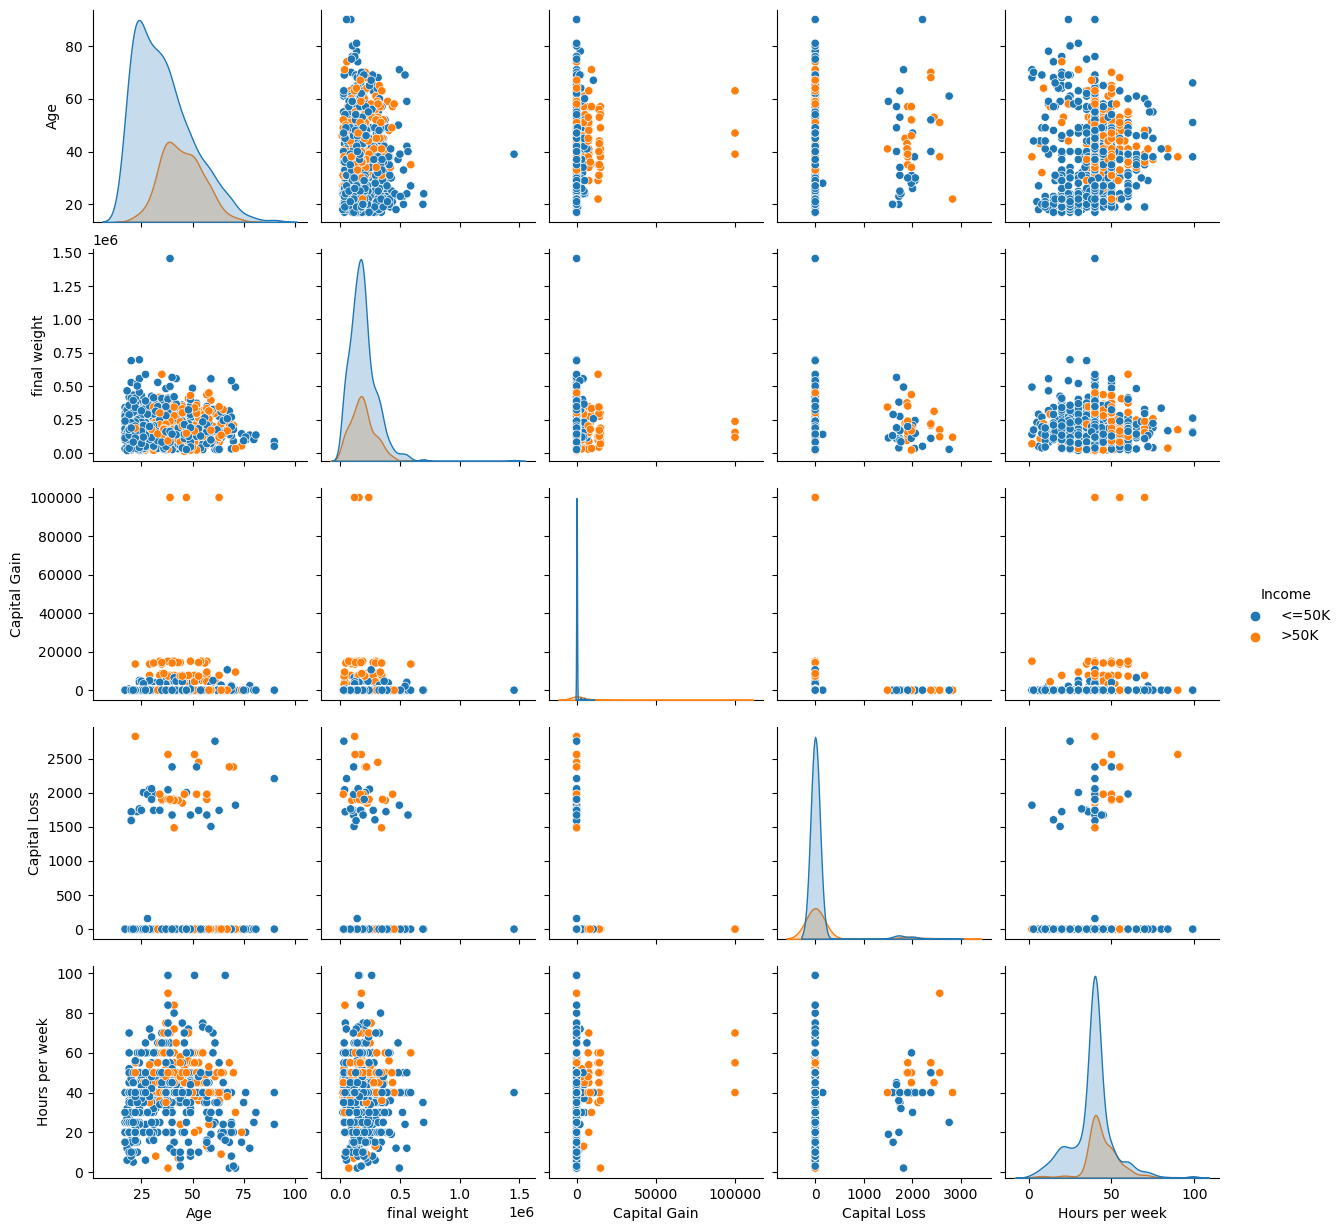

In [82]:
# check correlation, type of distribution and relationship with the target
sns.pairplot(
    data=data.astype(
        dict(zip(quantitative_list, len(quantitative_list) * ["float32"]))
    ).sample(1000),
    hue=TARGET,
    vars=quantitative_list,
)

# NOTE: plot subsample of dataset to speed up the computation
# NOTE: coerce numerical features to float32 otherwise seaborn will complain

In [83]:
dict_results = correlation_analysis(
    data=data[quantitative_list].astype(np.float32), dropna="listwise", check_norm=True
)
display(dict_results["summary"].round(3))

,analysis,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman Rank,Age,final weight,-0.078,0.000,True,26016
1,Spearman Rank,Age,Capital Gain,0.124,0.000,True,26016
2,Spearman Rank,Age,Capital Loss,0.063,0.000,True,26016
3,Spearman Rank,Age,Hours per week,0.144,0.000,True,26016
4,Spearman Rank,final weight,Capital Gain,-0.014,0.020,True,26016
5,Spearman Rank,final weight,Capital Loss,-0.007,0.287,False,26016
6,Spearman Rank,final weight,Hours per week,-0.021,0.001,True,26016
7,Spearman Rank,Capital Gain,Capital Loss,-0.066,0.000,True,26016
8,Spearman Rank,Capital Gain,Hours per week,0.096,0.000,True,26016
9,Spearman Rank,Capital Loss,Hours per week,0.054,0.000,True,26016


In [84]:
# check statistical significance between feature and target
df_summary_ttest = pd.DataFrame()

# loop through list
for col in quantitative_list:
    # carry out t-test
    df_ttest, _ = independent_t_test(
        data=data,
        feature=col,
        grouping_var=TARGET,
        grouping_grp1=data[TARGET].unique()[0],
        grouping_grp2=data[TARGET].unique()[1],
        plot=False,
    )

    # concatenate to summary dataframe
    df_summary_ttest = pd.concat([df_summary_ttest, df_ttest], ignore_index=True)

display(df_summary_ttest)

,test-type,feature,group-var,group1,n-sample1,mean1 (std1),group2,n-sample2,mean2 (std2),variances,t-value,df,cohen_D,p-value,stat-sign
0,independent T-test,Age,Income,<=50K,19745,36.79 (14.02),>50K,6271,44.27 (10.47),Unequal,-45.129308,13992.602612,-0.564270,0.000000e+00,True
1,independent T-test,final weight,Income,<=50K,19745,190882.04 (106897.56),>50K,6271,187566.07 (100772.98),Unequal,2.236581,11102.022108,0.031445,2.533354e-02,True
2,independent T-test,Capital Gain,Income,<=50K,19745,148.06 (982.6),>50K,6271,3985.47 (14560.99),Unequal,-20.854624,6288.145101,-0.532998,1.898281e-93,True
3,independent T-test,Capital Loss,Income,<=50K,19745,54.49 (314.69),>50K,6271,194.68 (596.94),Unequal,-17.826470,7407.307763,-0.349318,1.236286e-69,True
4,independent T-test,Hours per week,Income,<=50K,19745,38.89 (12.33),>50K,6271,45.52 (11.01),Unequal,-40.330481,11666.596888,-0.551529,0.000000e+00,True


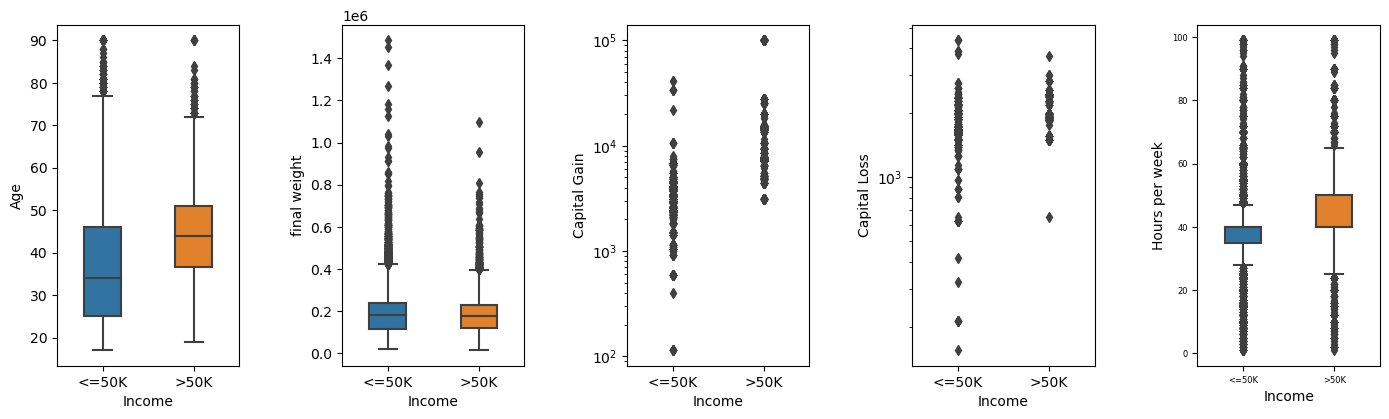

In [85]:
# create subplot with 5 plots
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(14, 4))
fig.tight_layout(w_pad=4.0)

# loop through tickers and axes
k = 0
for i in range(0, axs.shape[0]):
    # set log scale for two features to better visualize the group difference
    if (quantitative_list[k] == "Capital Gain") or (
        quantitative_list[k] == "Capital Loss"
    ):
        axs[i].set_yscale("log")

    _ = sns.boxplot(
        ax=axs[i],
        x=TARGET,
        y=quantitative_list[k],
        data=data,
        width=0.4,
    )

    k += 1

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()

Create a new binary feature from `Capital Gain` and `Capital Loss`, with `capital-invested` if `Capital Gain + Capital Loss = 0` and `capital-not-invested` otherwise.

In [86]:
# check percentage of zero in Capital Gain and Capital Loss
print(
    "o Percentage of zero in Capital Gain: ",
    round(data["Capital Gain"].loc[lambda x: x == 0].shape[0] / data.shape[0], 3),
)
print(
    "o Percentage of zero in Capital Loss: ",
    round(data["Capital Loss"].loc[lambda x: x == 0].shape[0] / data.shape[0], 3),
)

# generate new feature with Capital Gain and Capital Loss
data = data.assign(
    **{
        "Capital Gain-Loss": lambda x: x["Capital Gain"] - x["Capital Loss"],
        "Capital Invested": lambda x: np.where(
            x["Capital Gain-Loss"] == 0, "yes", "no"
        ),
    }
)

print(
    "o Percentage of zero in Capital Gain-Loss: ",
    round(data["Capital Gain-Loss"].loc[lambda x: x == 0].shape[0] / data.shape[0], 3),
)

# apply chi2 on new feature
_ = chisquare(data=data, groups="Capital Invested", categories=TARGET, show=True)

o Percentage of zero in Capital Gain:  0.918
o Percentage of zero in Capital Loss:  0.953
o Percentage of zero in Capital Gain-Loss:  0.871


,<=50K,>50K,Total count,Total count %
Capital Invested,,,,
no,1419,1943,3362,12.92
yes,18326,4328,22654,87.08


,test-type,grouping-var,categories,chi-square,df,p-value,stat-sign
0,chisquare,Capital Invested,Income,2395.222905,1,0.0,True


Create a categorical feature with three facets from `Hours per week` as follows:

In [87]:
data["Hours per week-approx"] = np.nan  # initialize with NaN
data.loc[lambda x: x["Hours per week"] < 40, "Hours per week-approx"] = "Part-time"
data.loc[lambda x: x["Hours per week"] == 40, "Hours per week-approx"] = "Full-time"
data.loc[lambda x: x["Hours per week"] > 40, "Hours per week-approx"] = "Over-time"

# enforce data type and order
data["Hours per week-approx"] = data["Hours per week-approx"].astype(
    CategoricalDtype(categories=["Part-time", "Full-time", "Over-time"], ordered=True)
)

# check Education-approx with chi2 square:
_ = chisquare(data=data, groups="Hours per week-approx", categories=TARGET, show=True)

,<=50K,>50K,Total count,Total count %
Hours per week-approx,,,,
Part-time,5570,581,6151,23.64
Full-time,9564,2609,12173,46.79
Over-time,4611,3081,7692,29.57


,test-type,grouping-var,categories,chi-square,df,p-value,stat-sign
0,chisquare,Hours per week-approx,Income,1839.673705,2,0.0,True


In [88]:
# cast new features to categorical datatype
data = data.astype(
    {
        "Workclass-approx": "category",
        "MaritalStatus-approx": "category",
        "Occupation-approx": "category",
        "Ethnicity-approx": "category",
        "Country-approx": "category",
        "Capital Invested": "category",
    }
)

# save data in parquet format to retain data type. Note: It requires pyarrow and fastparquet library
data.to_parquet("./data/data_train_cleaned.parquet")

## Train quick model

In [89]:
# drop na values for now
data = data.dropna(how="any")

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=TARGET), data[TARGET], test_size=0.2, random_state=42
)

# convert TARGET to binary  0/1
y_train = y_train.map({"<=50K": 0, ">50K": 1})
y_test = y_test.map({"<=50K": 0, ">50K": 1})

**Test1:** Run the model with original features

In [90]:
# scale numerical features using StandardScaler
quantitative_features = [
    "Age",
    "final weight",
    "Education-Num",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
]
categorical_features = [
    "Workclass",
    "Marital Status",
    "Occupation",
    "Relationship",
    "Ethnic group",
    "Sex",
    "Country",
]

X_train_num, X_test_num = normlize_data(X_train, X_test, quantitative_features)
X_train_cat, X_test_cat = encode_categorical_features(
    X_train, X_test, categorical_features
)

X_train_1 = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_1 = pd.concat([X_test_num, X_test_cat], axis=1)

# Fit logistic regression using sklearn
_ = logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_1, y_train)

report_lr_original = classification_report(
    y_true=y_test,
    y_pred=logreg.predict(X_test_1),
    label="LR original",
    show_description=False,
)

# Fit random forest using sklearn
_ = rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42)
rf.fit(X_train_1, y_train)

report_rf_original = classification_report(
    y_true=y_test,
    y_pred=rf.predict(X_test_1),
    label="RF original",
    show_description=False,
)

# Fit QDA using sklearn
qda = QuadraticDiscriminantAnalysis()
_ = qda.fit(X_train_1, y_train)

report_qda_original = classification_report(
    y_true=y_test,
    y_pred=qda.predict(X_test_1),
    label="QDA original",
    show_description=False,
)

/Users/giovanni/opt/anaconda3/envs/dv-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/giovanni/opt/anaconda3/envs/dv-env/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


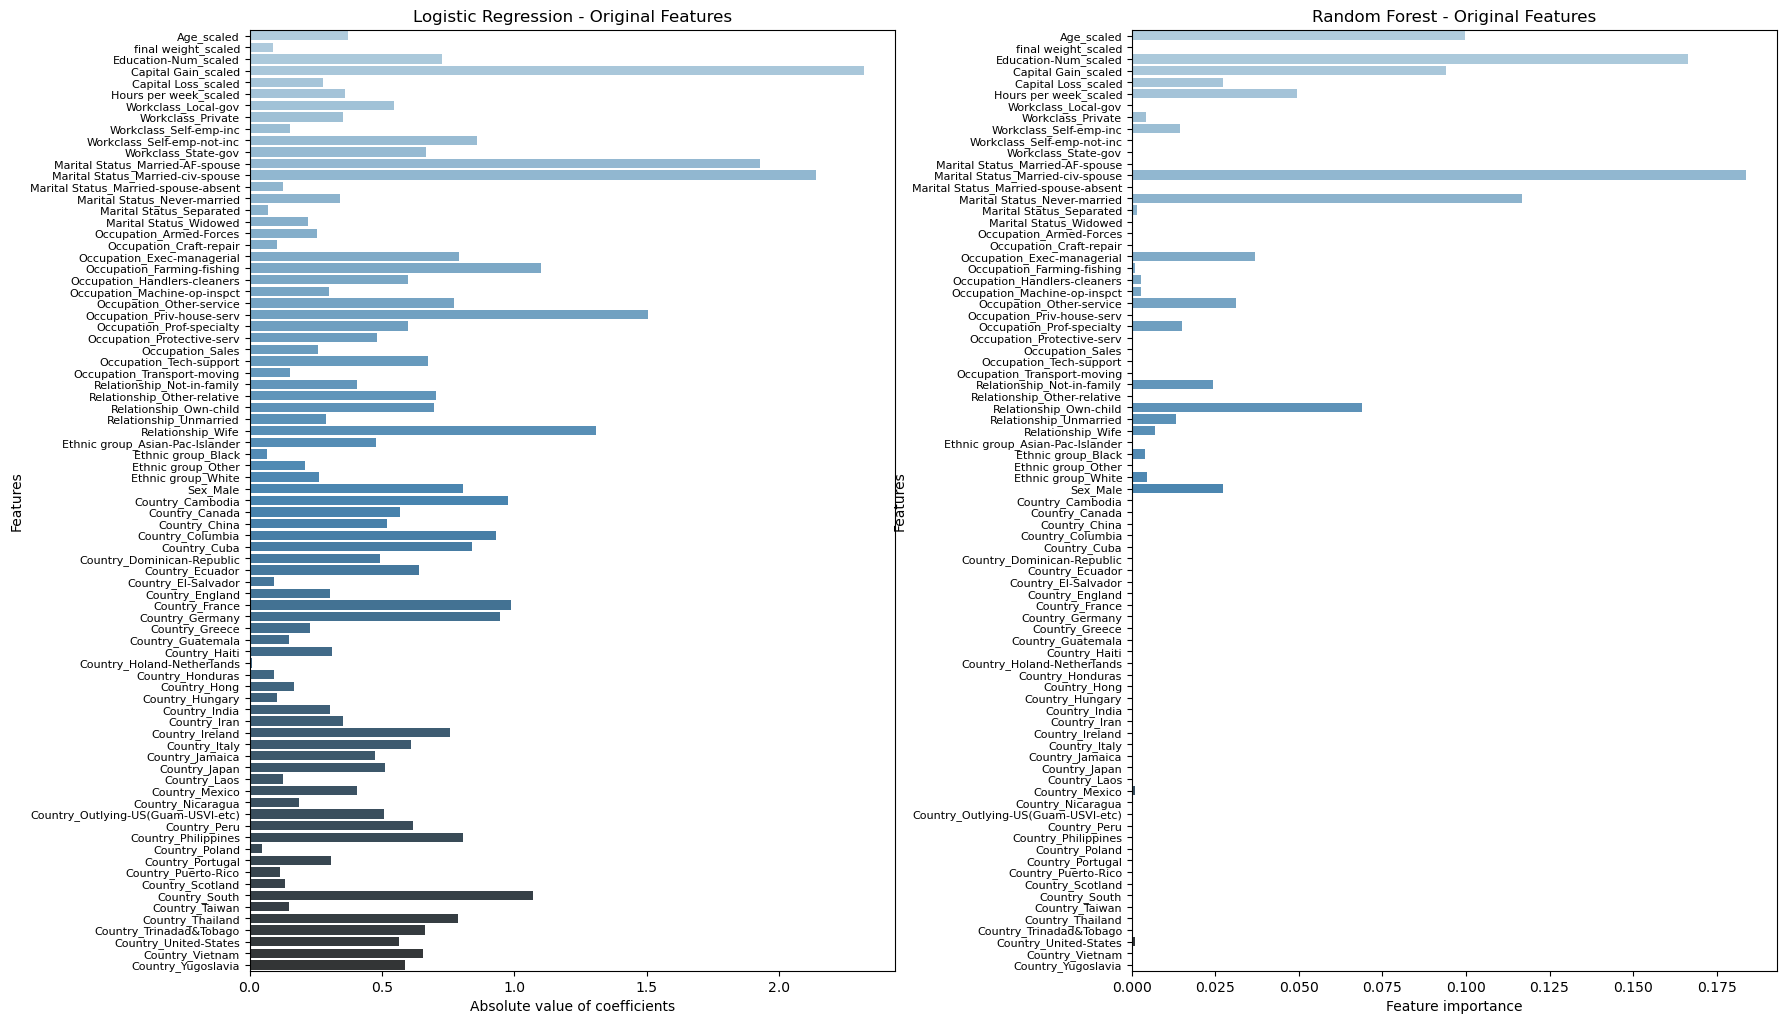

In [91]:
# plot barplot with coefficients sorted by absolute value
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
fig.tight_layout(w_pad=14.0)

ax = sns.barplot(
    x=np.abs(logreg.coef_[0]),
    y=X_train_1.columns,
    orient="h",
    palette="Blues_d",
    ax=axs[0],
)
# reduce font size y label
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax.set_title("Logistic Regression - Original Features")
ax.set_xlabel("Absolute value of coefficients")
ax.set_ylabel("Features")

# plot barplot of feature importance from random forest
ax = sns.barplot(
    x=rf.feature_importances_,
    y=X_train_1.columns,
    orient="h",
    palette="Blues_d",
    ax=axs[1],
)
# reduce font size y label
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax.set_title("Random Forest - Original Features")
ax.set_xlabel("Feature importance")
ax.set_ylabel("Features")
plt.show()

**Test2:** Run the model with approximated features

In [92]:
quantitative_features = ["Age", "final weight"]
categorical_features = [
    "Sex",
    "Workclass-approx",
    "MaritalStatus-approx",
    "Occupation-approx",
    "Relationship-approx",
    "Ethnicity-approx",
    "Country-approx",
    "Education-approx",
    "Capital Invested",
    "Hours per week-approx",
]

X_train_num, X_test_num = normlize_data(X_train, X_test, quantitative_features)
X_train_cat, X_test_cat = encode_categorical_features(
    X_train, X_test, categorical_features
)

X_train_2 = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_2 = pd.concat([X_test_num, X_test_cat], axis=1)

# Fit logistic regression using sklearn
_ = logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_2, y_train)

report_lr_approx = classification_report(
    y_true=y_test,
    y_pred=logreg.predict(X_test_2),
    label="LR approx",
    show_description=False,
)

# Fit random forest using sklearn
_ = rf = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=42)
rf.fit(X_train_2, y_train)

report_rf_approx = classification_report(
    y_true=y_test,
    y_pred=rf.predict(X_test_2),
    label="RF approx",
    show_description=False,
)

# Fit QDA using sklearn
qda = QuadraticDiscriminantAnalysis()
_ = qda.fit(X_train_2, y_train)

report_qda_approx = classification_report(
    y_true=y_test,
    y_pred=qda.predict(X_test_2),
    label="QDA approx",
    show_description=True,
)

/Users/giovanni/opt/anaconda3/envs/dv-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


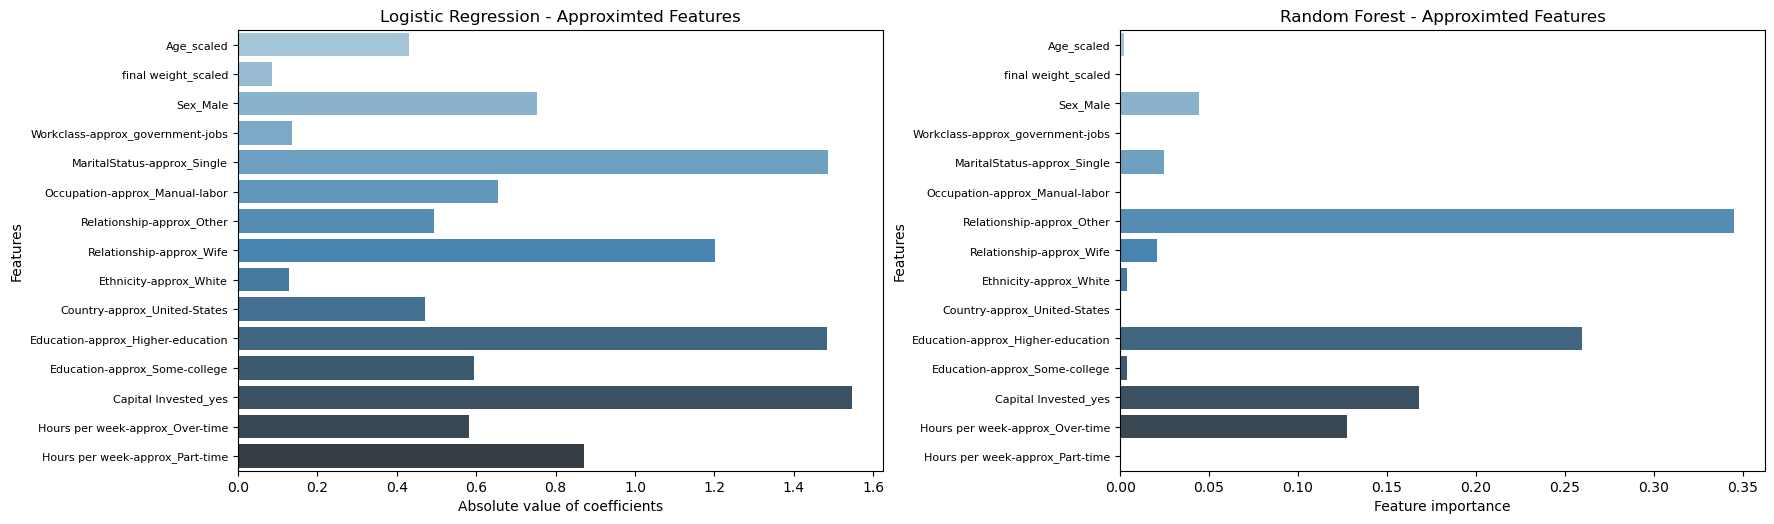

In [93]:
# plot barplot with coefficients sorted by absolute value
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
fig.tight_layout(w_pad=14.0)

ax = sns.barplot(
    x=np.abs(logreg.coef_[0]),
    y=X_train_2.columns,
    orient="h",
    palette="Blues_d",
    ax=axs[0],
)
# reduce font size y label
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax.set_title("Logistic Regression - Approximted Features")
ax.set_xlabel("Absolute value of coefficients")
ax.set_ylabel("Features")

# plot barplot of feature importance from random forest
ax = sns.barplot(
    x=rf.feature_importances_,
    y=X_train_2.columns,
    orient="h",
    palette="Blues_d",
    ax=axs[1],
)
# reduce font size y label
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax.set_title("Random Forest - Approximted Features")
ax.set_xlabel("Feature importance")
ax.set_ylabel("Features")
plt.show()

In [94]:
# merge reports
report = pd.concat(
    [
        report_lr_original,
        report_rf_original,
        report_qda_original,
        report_lr_approx,
        report_rf_approx,
        report_qda_approx,
    ],
    axis=1,
)
# display report with extended width
with pd.option_context("display.max_colwidth", 1000):
    display(report)

,LR original,RF original,QDA original,LR approx,RF approx,QDA approx,Description
True Positive (TP),713.00,29.00,1153.00,660.00,190.00,854.00,The number of real positive cases in the data that are correctly classified as positive by the model
True Negative (TN),3398.00,3695.00,508.00,3343.00,3663.00,3042.00,The number of real negative cases in the data that are correctly classified as negative by the model
False Positive (FP),297.00,0.00,3187.00,352.00,32.00,653.00,The number of real negative cases in the data that are incorrectly classified as positive by the model
False Negative (FN),497.00,1181.00,57.00,550.00,1020.00,356.00,The number of real positive cases in the data that are incorrectly classified as negative by the model
True Positive (TP) %,14.54,0.59,23.51,13.46,3.87,17.41,The percentage of real positive cases in the data that are correctly classified as positive by the model
True Negative (TN) %,69.28,75.33,10.36,68.15,74.68,62.02,The percentage of real negative cases in the data that are correctly classified as negative by the model
False Positive (FP) %,6.06,0.00,64.97,7.18,0.65,13.31,The percentage of real negative cases in the data that are incorrectly classified as positive by the model
False Negative (FN) %,10.13,24.08,1.16,11.21,20.80,7.26,The percentage of real positive cases in the data that are incorrectly classified as negative by the model
Condition Positive (P),1210.00,1210.00,1210.00,1210.00,1210.00,1210.00,The number of real positive cases in the data
Condition Negative (N),3695.00,3695.00,3695.00,3695.00,3695.00,3695.00,The number of negative positive cases in the data


In [95]:
# Fit logistic regression with statsmodels to get p-values
logit = sm.Logit(y_train, sm.add_constant(X_train_1))
result = logit.fit()

# Store coefficients and p-values in dataframe
coefficient_values = result.params

# Concatenate coefficients and p-values
df_coef_pval = (
    pd.concat([coefficient_values, result.pvalues], axis=1)
    .rename(columns={0: "coef", 1: "p-value"})
    .assign(stat_sign=lambda x: np.where(x["p-value"] < 0.05, "yes", "no"))
)

# display all rows
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_coef_pval.loc[lambda x: x["stat_sign"] == "yes"])

         Current function value: 0.322837
         Iterations: 35


/Users/giovanni/opt/anaconda3/envs/dv-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,coef,p-value,stat_sign
const,-4.459886,1.220850e-18,yes
Age_scaled,0.376726,2.122909e-42,yes
final weight_scaled,0.089328,1.171359e-04,yes
Education-Num_scaled,0.726222,2.073022e-122,yes
Capital Gain_scaled,2.348122,4.855417e-132,yes
Capital Loss_scaled,0.276728,1.535434e-45,yes
Hours per week_scaled,0.362322,1.886510e-46,yes
Workclass_Local-gov,-0.575892,3.218642e-05,yes
Workclass_Private,-0.377953,1.055892e-03,yes
Workclass_Self-emp-not-inc,-0.885841,6.064620e-11,yes


In [96]:
# Fit logistic regression with statsmodels to get p-values
logit = sm.Logit(y_train, sm.add_constant(X_train_2))
result = logit.fit()

# Store coefficients and p-values in dataframe
coefficient_values = result.params

# Concatenate coefficients and p-values
df_coef_pval = (
    pd.concat([coefficient_values, result.pvalues], axis=1)
    .rename(columns={0: "coef", 1: "p-value"})
    .assign(stat_sign=lambda x: np.where(x["p-value"] < 0.05, "yes", "no"))
)

# display all rows
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_coef_pval)

Optimization terminated successfully.
         Current function value: 0.358063
         Iterations 7


,coef,p-value,stat_sign
const,-0.966683,1.182503e-12,yes
Age_scaled,0.433140,1.406941e-71,yes
final weight_scaled,0.086889,5.984027e-05,yes
Sex_Male,0.765256,3.141558e-19,yes
Workclass-approx_government-jobs,0.135547,1.963532e-02,yes
MaritalStatus-approx_Single,-1.556686,2.419416e-09,yes
Occupation-approx_Manual-labor,-0.656179,7.175463e-39,yes
Relationship-approx_Other,-0.421580,1.051795e-01,no
Relationship-approx_Wife,1.223358,3.071050e-25,yes
Ethnicity-approx_White,0.129208,6.863120e-02,no


- 'Relationship' has 2 out 5 coefficient not significant. One can try to further cluster to `Relashioship` 
-

**Summary Nominal features** TO FINISH
- All nominal features appear to have a significant relationship with the Target. However, many of them have several groups and high imbalance, which can lead to a degradation in the model performance and loss of generalisation when considering minority groups. Therefore the following transformations were be applied:
    - 1. For `Workclass`, we will discard the samples with category `Never-worked` and `Without-pay` as they have very few samples and always `Income<=50K`. Suppose a new sample during production will occur with such values during production. In that case, an ad-hoc logic will handle these cases by setting Income `<= 50K`, regardless of the other feature value. 
    - 2. For `Marital Status`, we will coerce `Married-AF-spouse` into `Married-civ-spouse` as there are very few and have a similar ratio per group. 
    - 3. For the `Ethnic group`, we see a massive imbalance between `White` and the other groups. Hence we will create a new nominal feature with groups `White` and `Others`. 
    - 4. For `Country`, we observe a huge imbalance between `United States` and the other groups. Hence we will create a new nominal feature with groups `United-States` and `Others`.
- Futhermore:
    - For `Occupation`, we expect that if such a feature is considered for model prediction, we expect that both `Armed-Forces` and `Priv-house-serv` will drive the prediction to `<=50K`.
    - For `Sex`, we observe that Female tendentially has an income of `<=50K`; however, in this cohort, there are 33% of females and 67% of male.

**Summary Ordinal features**
- `Income` is our target, and at this stage, the knowledge of prevalence (`0.24`) is sufficient.
- `Education` is related to `Education-Num` and is statistically significant based on chi2. 
- A new feature called `Education-approx` has been clustered into three groups, namely `{"HS-grad", "Some-college", "High-education"}` to reduce the imbalance, increase predictive power and improve fairness prediction (under the assumption this feature will be used for production). 